In [1]:
import pandas as pd
import numpy as np
import html, langid

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from time import time
from pathlib import Path
from bs4 import BeautifulSoup

DATA_PATH = '../data'
PLOT_PATH = '../docs/plots'
Path(PLOT_PATH).mkdir(exist_ok=True)

PAPERS_FILE = '{}/papers_22072019.csv.xz'.format(DATA_PATH)
WORKS_FILE  = '{}/works_22072019.csv.xz'.format(DATA_PATH)

In [2]:
# Artigos Data Read
df_papers = pd.read_csv(PAPERS_FILE, sep='|', compression='xz')
df_papers.drop(df_papers.loc[df_papers['idioma']!='Inglês'].index, inplace=True)
df_papers.drop(['id_doc','autores_cnpq','autores','idioma','revista','natureza'], axis=1, inplace=True)
df_papers.dropna(inplace=True)
df_papers.reset_index(inplace=True, drop=True)

# Trabalhos Data Read
df_works = pd.read_csv(WORKS_FILE, sep='|', compression='xz')
df_works.drop(df_works.loc[df_works['idioma']!='Inglês'].index, inplace=True)
df_works.drop(['id_doc','autores_cnpq','autores','idioma','anais','natureza'], axis=1, inplace=True)
df_works.dropna(inplace=True)
df_works.reset_index(inplace=True, drop=True)

print('{} df artigos\n{} df trabalhos'.format(df_papers.shape, df_works.shape))

(61154, 3) df artigos
(119965, 3) df trabalhos


In [3]:
# Concatena Dataframes
frames = [df_papers, df_works]
df = pd.concat(frames)
del [frames, df_papers, df_works]

df.drop_duplicates(inplace=True)
df.reset_index(inplace=True, drop=True)
df.sort_values(by=['id','ano'], ignore_index=True, inplace=True)

# Localiza dados invalidos para 'ano' / Converte 'ano' em int
df.drop(df.loc[~df['ano'].astype(str).str.isnumeric()].index, inplace=True)
df['ano'] = df['ano'].astype(int)

print('{} df shape'.format(df.shape))
df.dtypes

(180252, 3) df shape


id         int64
titulo    object
ano        int64
dtype: object

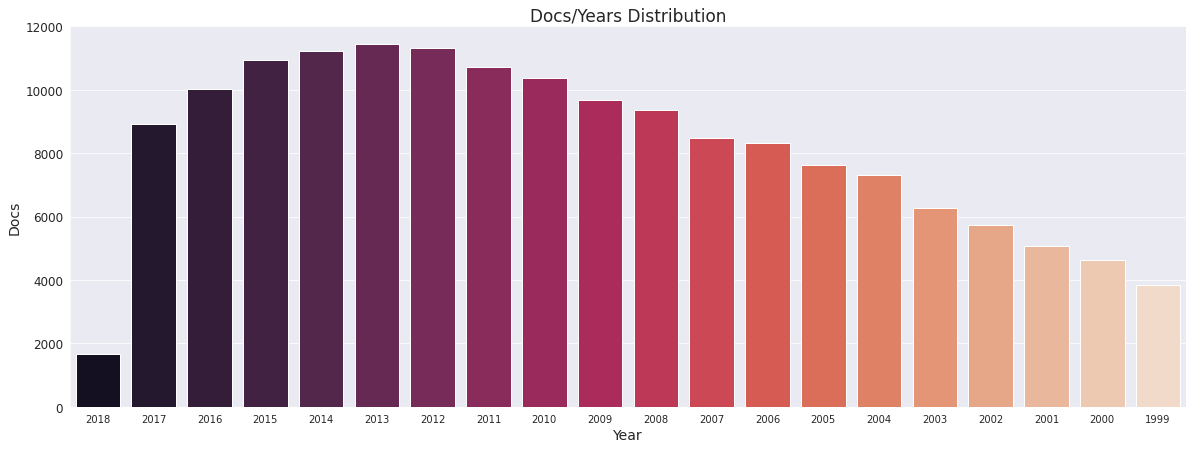

In [4]:
# Plota docs por ano
fig = plt.figure(figsize=(20,7))

docs_years = df['ano'].value_counts().sort_index(ascending=False).head(20)

x = docs_years.index
y = docs_years.values
    
g = sns.barplot(x=x, y=y, order=x, palette='rocket')
g.set_xticklabels(g.get_xticklabels(), fontsize=10)

plt.yticks(fontsize=12)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Docs', fontsize=14)
plt.title('Docs/Years Distribution', fontsize=17)

file_name = '{}/docs_years.png'.format(PLOT_PATH)
fig.savefig(file_name, dpi=fig.dpi, bbox_inches='tight')
plt.show()

In [5]:
# HTML Purge
def decode_html(doc):
    decoded = html.unescape(doc)
    return decoded

def strip_html(doc):
    soup = BeautifulSoup(doc, "html.parser")
    return soup.get_text()

def html_purge(doc):
    doc = decode_html(doc)
    doc = strip_html(doc)
    return doc

t = time()
df['titulo'] = df['titulo'].apply(html_purge)

print('Time: {} mins'.format(round((time() - t) / 60, 2)))
df.head(10)

Time: 0.28 mins


,id,titulo,ano
0,101982954114164,3D reconstruction methods for digital preserva...,2014
1,101982954114164,3D Viewer Software Build Based on Scanned Synt...,2016
2,102488447573085,The Globalization Strategy of a High-Tech Mult...,1996
3,102488447573085,Information Systems as an Instrument of Qualit...,2000
4,102488447573085,The Experience of a Cardiology Unit in the Dev...,2002
5,102488447573085,Information Systems as an Instrument for Quali...,2002
6,102488447573085,Clustering and Categorization Applied to Crypt...,2006
7,102488447573085,Criptoanalisys Outwit using Context Sensitive ...,2016
8,102488447573085,Cryptographic Algorithm Identification Using M...,2016
9,103102694865890,Influence of baroclinic sistems in severe rain...,2011


In [6]:
# Detect Language
def detect_language(doc):
    lang, log_prob = langid.classify(doc)
    if lang != 'en':
        return np.nan
    return doc

t = time()
df['titulo'] = df['titulo'].apply(detect_language)
df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

print('{} df shape'.format(df.shape))
print('Time: {} mins'.format(round((time() - t) / 60, 2)))

(172165, 3) df shape
Time: 17.88 mins


In [7]:
# Save
pre_file = '{}/01pre_lattes.pkl.xz'.format(DATA_PATH)
%time df.to_pickle(pre_file, compression='xz')

CPU times: user 22 s, sys: 164 ms, total: 22.2 s
Wall time: 22.5 s
